In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/style-transfer"))
print(os.listdir("../input/deepdream"))
# Any results you write to the current directory are saved as output.

['style-transfer', 'deepdream']
['portrait.jpg', 'test_transfer.png', 'scene.jpg', 'cat.png', 'style.png', 'test.png']
['Ireland.NorthernIReland.CarrickaRede.SS_.jpg']


In [2]:
# In short, you can use a pretrained convnet to define a loss that will do the following:
# - Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The convnet should "see" both the target image and the generated image as containing the same things.
# - Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Feature correlations capture textures: the generated image and the style-reference image should share the same textures at different spatial scales.

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step
Start of iteration 0
88817040000.0
Iteration 0 completed in 12s
Start of iteration 1
50585117000.0
Iteration 1 completed in 4s
Start of iteration 2
40070960000.0
Iteration 2 completed in 4s
Start of iteration 3
37291320000.0
Iteration 3 completed in 4s
Start of iteration 4
36139307000.0
Iteration 4 completed in 4s
Start of iteration 5
35484926000.0
Iteration 5 completed in 4s
Start of iteration 6
35060187000.0
Iteration 6 completed in 4s
Start of iteration 7
34764526000.0
Iteration 7 completed in 4s
Start of iteration 8
34554050000.0
Iteration 8 completed in 4s
Start of iteration 9
34396240000.0
Iteration 9 completed in 4s


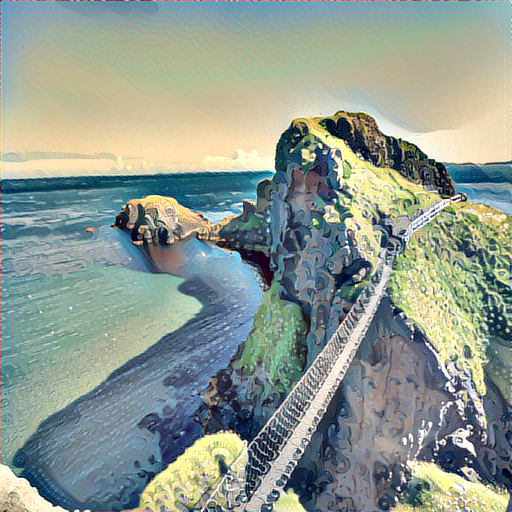

In [3]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

content_image=Image.open('../input/deepdream/Ireland.NorthernIReland.CarrickaRede.SS_.jpg')
content_image=content_image.resize((512,512))
style_image= Image.open('../input/style-transfer/style.png')
style_image=style_image.resize((512,512))

content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)

style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

layers=dict([(layer.name, layer.output) for layer in model.layers])

loss=backend.variable(0.)

def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

layer_features=layers['block2_conv2']
content_image_features=layer_features[0,:,:,:]
combination_features=layer_features[2,:,:,:]
loss+=content_weight*content_loss(content_image_features,combination_features)

def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl
    
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)

outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator=Evaluator()

x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

In [4]:
# Make sure that the processed images are a similar size (widely different sizes make style transfer more difficult).
"""Defining initial variables"""
from keras.preprocessing.image import load_img, img_to_array

target_image_path = '../input/style-transfer/test_transfer.png'
style_reference_image_path = '../input/style-transfer/style.png'

# Dimensions of the generated picture
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

# Create some auxiliary functions for loading, preprocessing and postprocessing the images that go in and out of the VGG19 convnet.
"""Auxiliary functions"""
import numpy as np
from keras.applications import vgg16

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img
def deprocess_image(x):
    # Zero-centering by removing the mean pixel value from ImageNet. This reverse a transformation done by vgg19.preprocess_input
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # Convert images from 'BGR' to 'RGB'. This is also part of the reversal of vgg19.preprocess_input
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# VGG19 network takes as input a batch of three images: the stype-reference image, the target image and a placecholder that will contain the generated image.
# A placeholder is a symbolic tensor, the values of which are provided externally via Numpy arrays.
# The style-reference and target image are static and thus defined using K.constant, whereas the values constrained in the placeholder will change over time.
"""Loading the pretrained VGG19 network and applying it to the three images"""
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3)) # Placeholder that will contain the generated image

# Combine the three images in a single batch
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

# Build the VGG19 network with the batch of three images as input
model = vgg16.VGG16(input_tensor = input_tensor, weights='imagenet', include_top=False)
print('Model loaded.')

"""Content loss"""
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

"""Style loss"""
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# The total variation loss operates on the pixels of the generated combination image.
# It encourages spatial continuity in the generated image, thus avoiding overly pixelated results.
# You can interpret it as a regularization loss.
"""Total variation loss"""
def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :]
                - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :]
                - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# The loss that you minimize is a weighted average of these three losses.
# To compute the content loss, you use only one upper layer - the block5_conv2 layer - whereas for the style loss, you use a list of layers than spans both low-level and high-level layers.
# You add the total variation loss at the end.

# Depending on the style-reference image and content image you're using, you'll likely want to tune the content_weight coefficient (the contribution of the content loss to the total loss).
# A higher content-weight means the target content will be more recognizable in the generated image.
"""Defining the final loss that you'll minimize"""
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block2_conv2' # Layer used for content loss
style_layers = ['block1_conv1', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3'] # Layers used for style loss
# Weights in the weighted average of the loss components
total_variation_weight = 1.
style_weight = 5.
content_weight = 0.05
# Add the content loss
loss = K.variable(0.) # You'll define the loss by adding all components to this scalar variable
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers: # Add a style loss component for each target layer
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image) # Add the total variation loss

Model loaded.


In [5]:
# In the original paper, optimization is performed using the L-BFGS algorithm.
# The L-BFGS algorithm comes packaged with SciPy, but there are two slight limitations:
# - It requires that you pass the value of the loss function and the value of the gradients as two separate functions
# - It can only be applied to flat vectors, whereas you have a 3D image array.
# It would be inefficient to compute the value of the loss function and the value of the gradients independently, because doing so would lead to a lot of redundant computation between the two.
# To bypass this, you'll set up a Python class named Evaluator that computes both the loss value and the gradients value at once, returns the loss value when called the first time, and catches the gradients for the next call.
"""Setting up the gradient-descent process"""
grads = K.gradients(loss, combination_image)[0] # Get the gradients of the generated image with regard to loss

fetch_loss_and_grads = K.function([combination_image], [loss, grads]) # Function to fetch the values of the current loss and the current gradients

# This class wraps fetch_loss_and_grads in a way that lets you retrieve the losses and gradients via two separate method calls.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [6]:
"""Style-transfer loop"""
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 10

x = preprocess_image(target_image_path) # This is the initial state: the target image
x = x.flatten() # You flatten the image because scipy.optimize.fmin_l_bfgs_b can only process flat vectors
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, infor = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration%d.png' % i
    imsave(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 47694696000.0
Image saved as my_result_at_iteration0.png
Iteration 0 completed in 6s
Start of iteration 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 40205074000.0
Image saved as my_result_at_iteration1.png
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 36839280000.0
Image saved as my_result_at_iteration2.png
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 35641524000.0
Image saved as my_result_at_iteration3.png
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 35160834000.0
Image saved as my_result_at_iteration4.png
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 34924536000.0
Image saved as my_result_at_iteration5.png
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 34781650000.0
Image saved as my_result_at_iteration6.png
Iteration 6 completed in 4s
Start of iteration 7
Current loss value: 34685410000.0
Image saved as my_result_at_iteration7.png
Iteration 7 completed in 4s
Start of iteration 8
Current loss value: 34617840000.0
Image saved as my_result_at_iteration8.png
Iteration 8 completed in 4s
Start of iter

In [7]:
# The algorithm is closer to classical signal processing than to AI.
# Note that running this style-transfer algorithm is slow.
# But the transformation operated by the setup is simple enough that it can be learned by a small, fast feedforward convnet as well - as long as you have appropriate training data available.
# Fast style transfer can thus be achieved by first spending a lot of compute cycles to generate input-output training examples for a fixed style-reference image, using the method outlined here, then training a simple convnet to learn this style-specific transformation.
# Once that's done, stylizing a given image is instantaneous: it's just a foward pass of this small convnet.

In [8]:
"""Wrapping up"""
# - Style transfer consists of creating a new image that preserves the contents of a target image while also capturing the style of a reference image.
# - Content can be captured by the high-level activations of a convnet.
# - Style can be captured by the internal correlations of the activations of different layers of a convnet.
# - Hence, deep learning allows style transfer to be formulated as an optimization process using a loss defined with a pretrained convnet.
# - Starting from this basic idea, many variants and refinements are possible.

'Wrapping up'